# Imports

In [2]:
import numpy as np
import pandas as pd
import requests
import re
import warnings

from bs4 import BeautifulSoup
from configparser import ConfigParser
from datetime import datetime
from IPython.display import Image


warnings.filterwarnings('ignore')

# 1 Intro

We will scrap a brazilian online marketplace (OLX), to extrat data from used car ads to an future data science project.

As there are lots of ads and we are not going to run it on super computers, we atre going to use 2 filter parameters. The car model with the most saled model from last years in Brasil (GM - Onix) and the most populated region of Brazil (São Paulo - Zona Leste).

On current data (Jun, 22, 2022) the result page with filters looks like this and show us 624 results

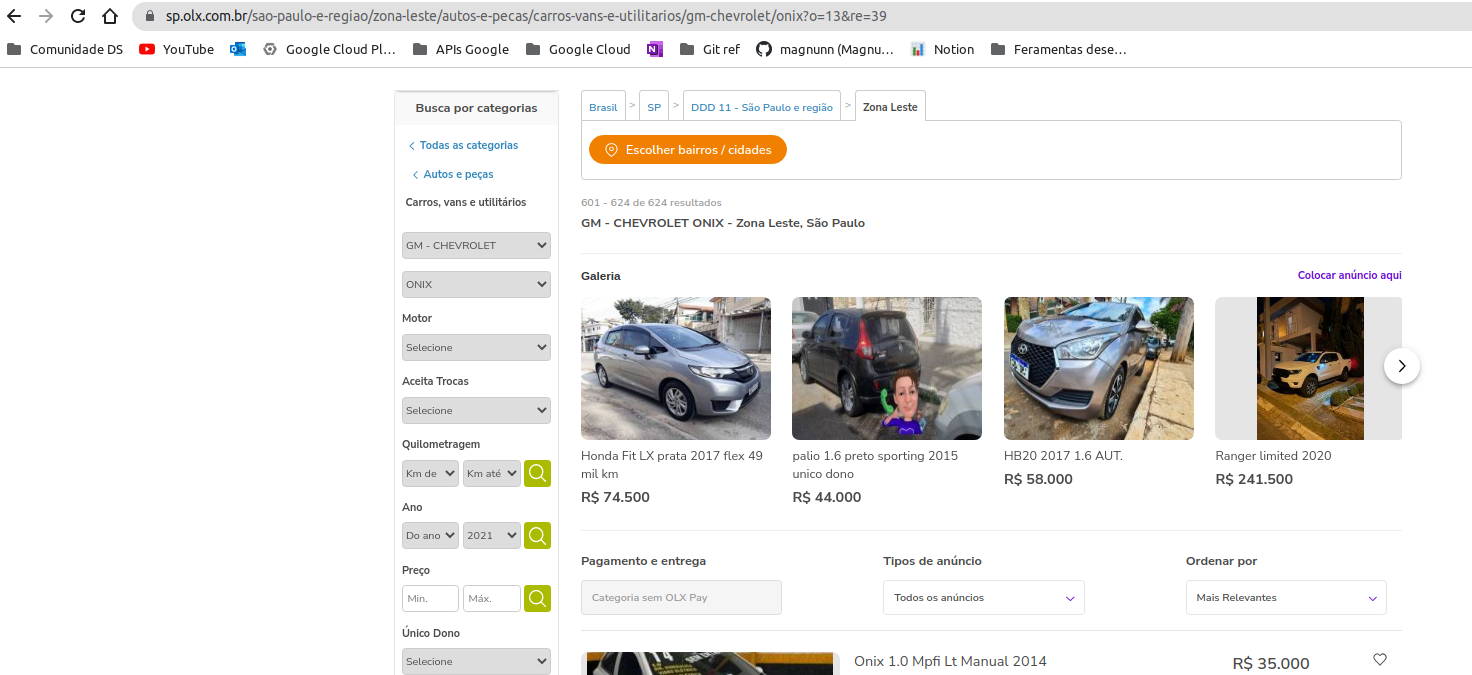

In [3]:
Image("img/page_sample.png")

# 2 Setup

To start our project I recomend using virtual eviroments. Some moments will be required to intera

In [2]:
config = ConfigParser()
config.read('config.ini')

['config.ini']

In [3]:
main_url = config['WEB_SITE_ELEMENTS_BY_CLASS']['main_url']
results_number_webclass = config['WEB_SITE_ELEMENTS_BY_CLASS']['results_num']
url_id_webclass = config['WEB_SITE_ELEMENTS_BY_CLASS']['url_id']
price_webclass = config['WEB_SITE_ELEMENTS_BY_CLASS']['price']
desc_webclass = config['WEB_SITE_ELEMENTS_BY_CLASS']['desc']
features_webclass = config['WEB_SITE_ELEMENTS_BY_CLASS']['features']
accessories_webclass = config['WEB_SITE_ELEMENTS_BY_CLASS']['accessories']
advertiser_webclass = config['WEB_SITE_ELEMENTS_BY_CLASS']['advertiser']
location_webclass = config['WEB_SITE_ELEMENTS_BY_CLASS']['location']
photo_num_webclass = config['WEB_SITE_ELEMENTS_BY_CLASS']['photo_num']
results_per_page = int(config['WEB_SITE_ELEMENTS_BY_CLASS']['page_results'])

# 4 Let's Scrap!

## 4.1 Instantiating BeautifulSoup

First let's Instantiate BeautifulSoup, our initial page (main_url) is that one resulting from filters detailed on "Intro"

In [4]:
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'} 
page_init = requests.get( main_url, headers=headers )
soup_init = BeautifulSoup( page_init.text, 'html.parser' )

## 4.2 Showcase Page

<b> Atention! The website has a limitator of 100 result pages, so avoid using a too open filters </b>

### 4.2.1 Getting number of results and calculating how many result pages is there.

 Below you can see a represetantion on how to use find_all(). <b>Be aware that searching for a 'class' my result in multiple results</b>

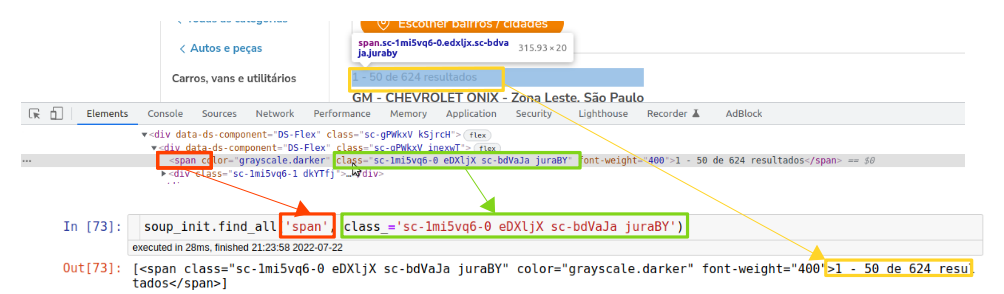

In [5]:
Image("img/find_all.png")

In [6]:
results_num_raw = soup_init.find_all('span', class_= results_number_webclass)

In [7]:
#Regex to get number of results
results_num_regex = '(\d+) resultados'

In [8]:
#Mapping number of total results and pages number
results_num = int(re.search(results_num_regex, str(results_num_raw)).group(1))
pages_num = int(np.ceil((results_num/results_per_page)))

### 4.2.2 Dealing with multiple result pages

As we navigate throw the result pages, there is a litle change on the URL as highlighted below. This will be considered on a loop function that will be used to collect data from every page

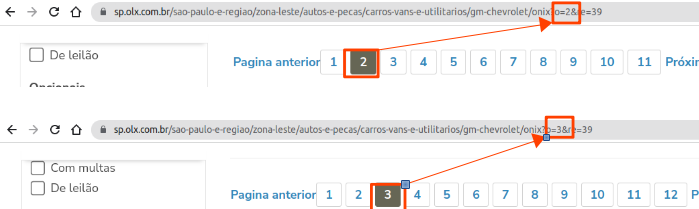

In [9]:
Image("img/page_navigation.png")

### 4.2.3 Getting ID and url for each ad listed

In [10]:
#Creating a dictdictionary with Product ID as the key and url as the value
catalog = {}

#Looping throw all results on each of results pages
for page in range (pages_num):
#for page in range (1):
    current_url = "https://sp.olx.com.br/sao-paulo-e-regiao/zona-leste/autos-e-pecas/carros-vans-e-utilitarios/gm-chevrolet/onix?o={}&re=39".format(page+1)
    page_current = requests.get( current_url, headers=headers )
    soup_current = BeautifulSoup( page_current.text, 'html.parser')
    #Listing all products containers on each page
    products = soup_current.find_all('a', class_= url_id_webclass)
    
    #Getting ID and URL of all products in the page
    for product in range (len(products)):
        catalog[products[product]['data-lurker_list_id']] = products[product]['href']

## 4.3 Product pages

In [11]:
def get_timestamp():
    dt = datetime.now()
    ts = datetime.timestamp(dt)
    
    return ts

In [12]:
#Creating an empty dataframe to be filled with details from each advertisement
catalog_df = pd.DataFrame()

#Loop accessing with car page and extract their data
for product in range(len(catalog)):
    product_page = requests.get(list(catalog.values())[product], headers=headers )
    soup_prod = BeautifulSoup(product_page.text, 'html.parser' )
    
    
    """Sometimes the data is unpatterned, not having some basic info like price and causing error on '.text.stripe()' 
    function, therefore we are using try/except structure. Lossing this unpatterned data don't seems to be a 
    problem, once on (07/23/2022 from 623 results only 1 was an exception)"""
    try:
        price = soup_prod.find('h2', class_= price_webclass).text.strip()
        description = soup_prod.find('h1', class_= desc_webclass).text.strip()
        features = soup_prod.find_all('div', class_= features_webclass)
        accessories = soup_prod.find_all('span', class_= accessories_webclass)
        advertiser = soup_prod.find_all('span', class_= advertiser_webclass)
        location = soup_prod.find_all('dd', class_= location_webclass)[2].text.strip()
        photo_num = len(soup_prod.find_all('img', class_= photo_num_webclass))-1

        #If the html element that describes the advertiser is a store is not empty, then the result is True
        if advertiser:
            advertiser = 'store'
        else:
            advertiser = 'person'

        #Creates a list with every accessory
        accessories_list = []
        for accessory in range(len(accessories)):
            accessories_list.append(accessories[accessory].text.strip())
        #Converting list to string (it will be easier to deal with SQL)
        accessories_string = ';'.join(accessories_list)

        #Create a dictionary with all car feartures within the main block of information
        features_dict = {}
        for feature in range(len(features)):
            features_dict[features[feature].findChildren()[0].text.strip()] = features[feature].findChildren()[1].text.strip()

        #Create a dictionary for each advertisement with its features
        prod_dict = {}
        prod_dict = {
            'id' : list(catalog.keys())[product],
            'url' : list(catalog.values())[product],
            'timestamp' : get_timestamp(),
            'description' : description,
            'price': price,
            'location' : location,
            'accessories' : accessories_string,
            'photo_num' : photo_num,
            'advertiser_type' : advertiser}
        #Add to the main product data the data stored data on features_dict
        prod_dict.update(features_dict)

        #Append to the final dictionary each advertisement ID as key and its features as value within a dictionary
        catalog_df = catalog_df.append(prod_dict, ignore_index=True)

    except:
        None

In [13]:
#renaming colluns equaling to DB
catalog_df.rename(columns={'Categoria' : 'vehicle_cat',
                           'Modelo' : 'model',
                           'Marca' : 'assembler',
                           'Tipo de veículo' : 'vehicle_type',
                           'Ano' : 'year',
                           'Quilometragem' : 'quilometers',
                           'Combustível' : 'gas_type',
                           'Câmbio' :'gearshift',
                           'Portas' : 'doors',
                           'Final de placa' : 'last_digit',
                           'Cor' : 'color',
                           'Direção' : 'steering_system',
                           'Kit GNV' : 'gnv_kit',
                           'Potência do motor' : 'cubic_cap'}, inplace=True)

In [14]:
catalog_df

,id,url,timestamp,description,price,location,accessories,photo_num,advertiser_type,vehicle_cat,...,year,quilometers,cubic_cap,gas_type,gearshift,steering_system,color,doors,last_digit,gnv_kit
0,1053396025,https://sp.olx.com.br/sao-paulo-e-regiao/autos...,1.659037e+09,Chevrolet Onix 2019 1.0 mpfi joy 8v flex 4p ma...,R$ 57.990,Vila Prudente,Vidro elétrico;Air bag;Trava elétrica;Ar condi...,7,store,"Carros, vans e utilitários",...,2019,29790,1.0,Flex,Manual,Hidráulica,Branco,4 portas,4,NaN
1,1064060800,https://sp.olx.com.br/sao-paulo-e-regiao/autos...,1.659037e+09,Chevrolet Onix 1.0 LT preto 8V flex,R$ 29.990,Tatuapé,,-1,person,"Carros, vans e utilitários",...,2014,96666,1.0,Flex,Manual,NaN,Preto,4 portas,NaN,Não
2,1054672268,https://sp.olx.com.br/sao-paulo-e-regiao/autos...,1.659037e+09,Chevrolet Onix 2016 1.4 mpfi lt 8v flex 4p manual,R$ 49.900,São Miguel Paulista,Vidro elétrico;Air bag;Trava elétrica;Ar condi...,13,store,"Carros, vans e utilitários",...,2016,82020,1.4,Flex,Manual,Hidráulica,Branco,4 portas,9,NaN
3,1064048395,https://sp.olx.com.br/sao-paulo-e-regiao/autos...,1.659037e+09,CHEVROLET ÔNIX LT 1.4 2016 AUTOMÁTICO,R$ 53.990,Jardim Independência,Vidro elétrico;Air bag;Trava elétrica;Ar condi...,10,store,"Carros, vans e utilitários",...,2016,78000,1.4,Flex,Automático,Elétrica,Prata,NaN,0,NaN
4,1047569759,https://sp.olx.com.br/sao-paulo-e-regiao/autos...,1.659037e+09,Chevrolet Onix 2021 1.0 flex lt manual,R$ 73.990,Vila Prudente,Vidro elétrico;Air bag;Trava elétrica;Ar condi...,7,store,"Carros, vans e utilitários",...,2021,60421,1.0,Flex,Manual,Elétrica,Branco,4 portas,2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
624,952671644,https://sp.olx.com.br/sao-paulo-e-regiao/autos...,1.659037e+09,Chevrolet Onix 1.0 Joy SPE/4 2017,R$ 45.889,Vila Regente Feijó,Vidro elétrico;Air bag;Trava elétrica;Ar condi...,13,store,"Carros, vans e utilitários",...,2017,61000,1.0,Flex,Manual,Hidráulica,Prata,4 portas,NaN,Não
625,1025976323,https://sp.olx.com.br/sao-paulo-e-regiao/autos...,1.659037e+09,Chevrolet Onix ONIX LT 1.4,R$ 57.999,Brás,Vidro elétrico;Trava elétrica;Ar condicionado;...,10,store,"Carros, vans e utilitários",...,2019,55000,NaN,Flex,Manual,Hidráulica,Prata,4 portas,8,NaN
626,1014134207,https://sp.olx.com.br/sao-paulo-e-regiao/autos...,1.659037e+09,Chevrolet Onix Plus 1.0 LT 2021 Flex - Manual,R$ 75.900,Conjunto Habitacional Teotonio Vilela,Vidro elétrico;Air bag;Trava elétrica;Ar condi...,12,store,"Carros, vans e utilitários",...,2021,42257,1.0,Flex,Manual,Elétrica,Prata,4 portas,2,Não
627,1009159067,https://sp.olx.com.br/sao-paulo-e-regiao/autos...,1.659037e+09,ONIX 2017/2018 1.0 MPFI LT 8V FLEX 4P MANUAL,R$ 53.989,Itaquera,Vidro elétrico;Air bag;Air bag;Trava elétrica;...,10,store,"Carros, vans e utilitários",...,2018,65124,NaN,Flex,Manual,NaN,NaN,4 portas,2,NaN
